In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn


In [2]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']
transform = transforms.ToTensor()

In [3]:
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

/home/assmac/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [4]:
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

x0, y0 = train_dataset[0]
print("One image tensor shape:", x0.shape)
print("One label:", y0, "->", labels[y0])

Train size: 50000
Test size: 10000
One image tensor shape: torch.Size([3, 32, 32])
One label: 6 -> frog


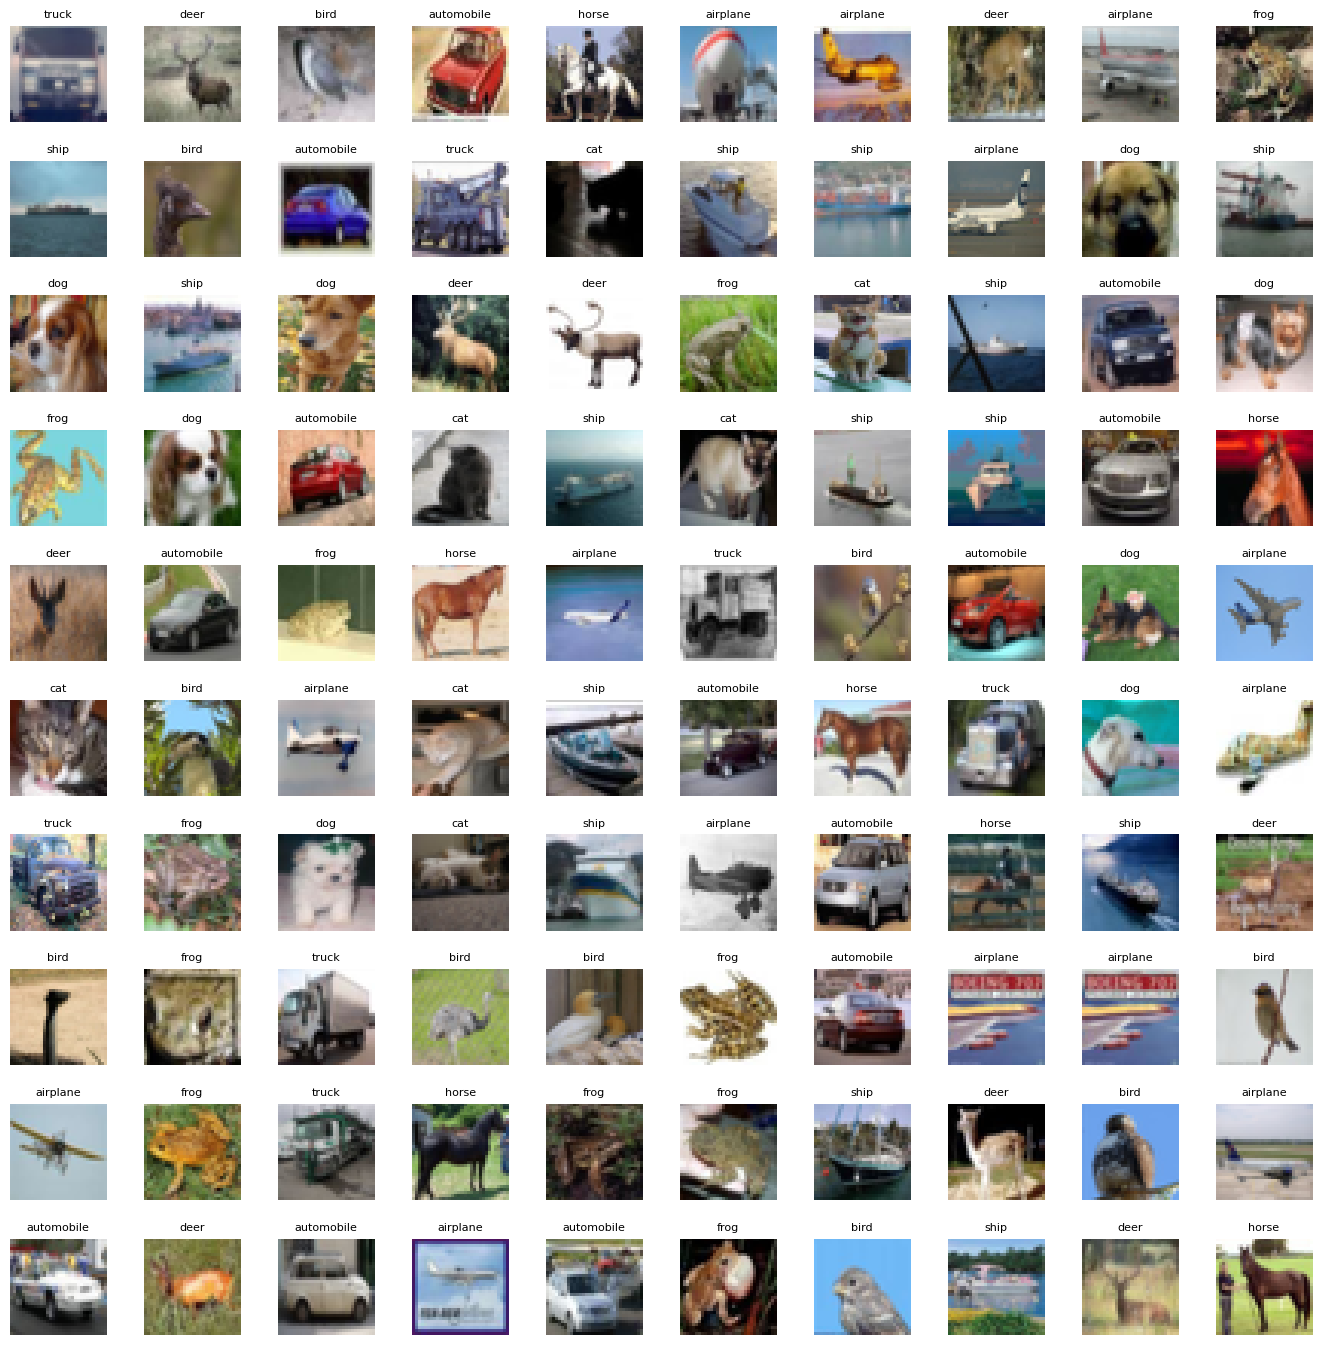

In [6]:
W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize=(17, 17))
axes = axes.ravel()

n_train = len(train_dataset)

for i in range(W_grid * L_grid):
    index = np.random.randint(0, n_train)

    img, label = train_dataset[index]

    img = img.permute(1, 2, 0).numpy()

    axes[i].imshow(img)
    axes[i].set_title(labels[label], fontsize=8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)
plt.show()


In [7]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
images, labels_batch = next(iter(train_loader))
print("Batch images shape:", images.shape)
print("Batch labels shape:", labels_batch.shape)


Batch images shape: torch.Size([128, 3, 32, 32])
Batch labels shape: torch.Size([128])


In [9]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [11]:
model = MLP().to(device)
print(model)
images, labels_batch = next(iter(train_loader))
images = images.to(device)

outputs = model(images)
print("Input batch shape:", images.shape)
print("Output shape:", outputs.shape)


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Input batch shape: torch.Size([128, 3, 32, 32])
Output shape: torch.Size([128, 10])


In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()  # met le modèle en mode "apprentissage"
    
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()          # remet les gradients à zéro
        outputs = model(images)        # prédictions (scores)
        loss = criterion(outputs, labels)  # calcule l'erreur
        loss.backward()                # calcule comment corriger les poids
        optimizer.step()               # applique la correction

        total_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)  # classe prédite = index du score max
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [14]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()  # mode "évaluation" (pas d'apprentissage)

    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [15]:
epochs = 10

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch:02d} | "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
          f"test_loss={test_loss:.4f} test_acc={test_acc:.4f}")


Epoch 01 | train_loss=1.8869 train_acc=0.3237 | test_loss=1.7357 test_acc=0.3830
Epoch 02 | train_loss=1.6891 train_acc=0.3975 | test_loss=1.6200 test_acc=0.4306
Epoch 03 | train_loss=1.6150 train_acc=0.4279 | test_loss=1.6179 test_acc=0.4202
Epoch 04 | train_loss=1.5682 train_acc=0.4446 | test_loss=1.5759 test_acc=0.4383
Epoch 05 | train_loss=1.5293 train_acc=0.4587 | test_loss=1.5375 test_acc=0.4563
Epoch 06 | train_loss=1.5135 train_acc=0.4640 | test_loss=1.5545 test_acc=0.4552
Epoch 07 | train_loss=1.4781 train_acc=0.4763 | test_loss=1.5205 test_acc=0.4574
Epoch 08 | train_loss=1.4555 train_acc=0.4832 | test_loss=1.4731 test_acc=0.4780
Epoch 09 | train_loss=1.4344 train_acc=0.4925 | test_loss=1.4869 test_acc=0.4680
Epoch 10 | train_loss=1.4122 train_acc=0.4991 | test_loss=1.4482 test_acc=0.4897


In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)

        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(labels.numpy())

all_preds = np.concatenate(all_preds)
all_true = np.concatenate(all_true)


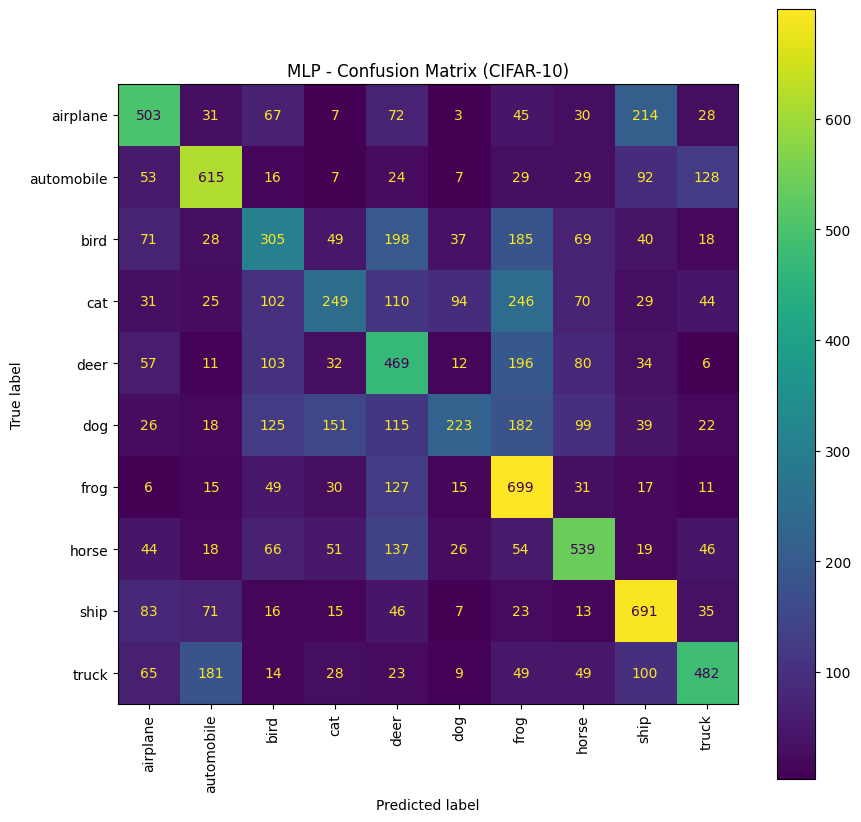

In [21]:
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cifar10_labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation="vertical")
plt.title("MLP - Confusion Matrix (CIFAR-10)")
plt.show()
